In [11]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import math 
import argparse

In [12]:
class Vaga:
    def __init__(self, x1, y1, x2, y2 ):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, cropping
 
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True
 
    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False 
        
        v = Vaga(refPt[0][0], refPt[0][1], refPt[1][0], refPt[1][1] )
        vagas.append(v)
        cv2.rectangle(image, refPt[0], refPt[1], (0, 255, 0), 2)
        clone = image.copy()
        #roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
        #cv2.imshow("image", img)
        #cv2.imshow("ROI", roi)

        # draw a rectangle around the region of interest


# Definir Vagas

In [13]:
# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
vagas = []
cropping = False

# load the image, clone it, and setup the mouse callback function
image = cv2.imread("img/12.png")
 
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
 
# keep looping until the 'q' key is pressed

while True:
    # display the image and wait for a keypress
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
     
    # if the 'r' key is pressed, reset the cropping region
    if key == ord("r"):
        del refPt[-1]
        #image = clone.copy()
 
    # if the 'c' key is pressed, break from the loop
    elif key == ord("c"):
        break
 
    # if there are two reference points, then crop the region of interest
# from teh image and display it
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow("ROI", roi)
    cv2.waitKey(0)
 
    # close all open windows
cv2.destroyAllWindows()
len(vagas)



parking_contours = []
parking_bounding_rects = []
parking_mask = []
for ind in range(0, len(vagas)):
    points = np.array([(vagas[ind].x1, vagas[ind].y1, vagas[ind].x1, vagas[ind].y2)] )
    ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
    rect = cv2.boundingRect(ctr)
    points_shifted = points.copy()
    points_shifted[:,0] = points[:,0] - rect[0] # shift contour to roi
    points_shifted[:,1] = points[:,1] - rect[1]
    parking_contours.append(ctr)
    parking_bounding_rects.append(rect)
    points_shifted = np.array(points_shifted).reshape((-1,1,2)).astype(np.int32)
    mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), points_shifted, contourIdx=-1, color=255, thickness=-1, lineType=cv2.LINE_8)
    mask = mask==255
    parking_mask.append(mask)

parking_status = [False]*len(vagas)
parking_buffer = [None]*len(vagas)

 # Processando Video

In [23]:
nomeVideo = "img/ifma.mp4"
videoSaida = "img/output.mp4"
cap = cv2.VideoCapture(nomeVideo)


config = {'save_video': False,
          'text_overlay': True,
          'parking_overlay': True,
          'parking_id_overlay': False,
          'parking_detection': True,
          'min_area_motion_contour': 60,
          'park_sec_to_wait': 3,
          'start_frame': 0} #35000

video_info = {'fps':    cap.get(cv2.CAP_PROP_FPS),
              'width':  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
              'num_of_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}

width =int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #Frame Inicial

while(cap.isOpened()):
    spot = 0
    occupied = 0 
         
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame = cap.read()   
    if ret == False:
        print("Erro de Captura")
        break
         
        
    # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()
    
    #parking_detection
    #Registrar no Video Vagas do Estacionamento                    
    for ind in range(0, len(vagas)):
        points = np.array([(vagas[ind].x1, vagas[ind].y1, vagas[ind].x1, vagas[ind].y2)])
        ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
        
        rect = parking_bounding_rects[ind]
        roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calculation   
        
        print rect
        print points

        points[:,0] = points[:,0] - rect[0] # shift contour to roi
        points[:,1] = points[:,1] - rect[1]
        
        status = np.std(roi_gray) < 22 and np.mean(roi_gray) > 53
        
        
        # If detected a change in parking status, save the current time
        if status != parking_status[ind] and parking_buffer[ind]==None:
            parking_buffer[ind] = video_cur_pos
        # If status is still different than the one saved and counter is open
        elif status != parking_status[ind] and parking_buffer[ind]!=None:
            if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                parking_status[ind] = status
                parking_buffer[ind] = None
        # If status is still same and counter is open                    
        elif status == parking_status[ind] and parking_buffer[ind]!=None:
            #if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
            parking_buffer[ind] = None                    
        # print(parking_status)
        
        
    if config['parking_overlay']:                    
        for ind in range(0, len(vagas)):
            points = np.array([(vagas[ind].x1, vagas[ind].y1, vagas[ind].x1, vagas[ind].y2)])
            ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
            points = np.array(points).reshape((-1,1,2)).astype(np.int32)
            if parking_status[ind]: 
                color = (0,255,0)
                spot = spot+1
            else: 
                color = (0,0,255)
                occupied = occupied+1
                
            cv2.drawContours(frame_out, points, contourIdx=-1,
                             color=color, thickness=2, lineType=cv2.LINE_8)
            cv2.drawContours(im,parking_contours[ind],-1,(255,255,0),3)
            
            #t1 = (points[0][0][0], int(points[1][0][1]*0.25)) 
            #t2 = (points[0][0][1] ,points[1][0][1] )
            #cv2.rectangle(frame_out, t1, t2 , color, 2)
            
            ##https://stackoverflow.com/questions/45448120/moments-of-many-objects-python-opencv
            ##https://www.learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/
            cx = np.empty([len(ctr), 1])
            cy = np.empty([len(ctr), 1])
            
            for i in range(0,len(ctr)):
                moments = cv2.moments(ctr[i])

                if moments['m00'] != 0:
                    cx[i]= int(moments['m10']/moments['m00'])-3
                    cy[i]= int(moments['m01']/moments['m00'])+3
                    centroid = (cx[i],cy[i])
                else:
                    centroid = (0,0)

            cv2.putText(frame_out, str(ind), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)
            # print 'occupied: ', occupied
            # print 'spot: ', spot

        
    # Draw Overlay
    if config['text_overlay']:
        #cv2.rectangle(frame_out, (1, 5), (280, 90),(255,255,255), 85)
        cv2.rectangle(frame_out, (1, 5), (210, 90),(255,255,255), 100) 
         
        str_on_frame = "Frames: %d/%d" % (video_cur_frame, video_info['num_of_frames'])
        cv2.putText(frame_out, str_on_frame, (5,30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0,128,255), 2, cv2.LINE_AA)
        str_on_frame = "Livre: %d Ocupado: %d" % (spot, occupied)
        cv2.putText(frame_out, str_on_frame, (5,90), cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, (0,128,255), 2, cv2.LINE_AA)

        
    # Salva the output frame
    if video_cur_frame % 35 == 0: # take every 30 frames
        fourcc = cv2.VideoWriter_fourcc('D','I','V','X')
        out = cv2.VideoWriter(videoSaida, -1, 25, (width, height))
        
    # Display video
    cv2.imshow('Deteccao de Vagas de Estacionamento', frame_out)
    cv2.waitKey(40)
    
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('img/frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump to frame
    
   
    
cap.release()
if config['save_video']: out.release()
cv2.destroyAllWindows()    

(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 

(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 

(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 

(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 

(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 368 697 667]]
(445, 372, 1, 300)
[[445 372 445 671]]
(697, 368, 1, 300)
[[697 

In [23]:
 len(ctr)

2

In [16]:
refPt[0][0], refPt[0][1], refPt[1][0], refPt[1][1] 

(720, 360, 906, 657)

In [17]:
#cv2.line(frame_out,tuple(np.ravel(points[0])), tuple(np.ravel(points[1])),(0,255,0),3)
#cv2.line(img_marcacao,tuple(np.ravel(points[2])), tuple(np.ravel(points[3])),(0,255,0),3)

#cv2.line(img_marcacao,tuple(np.ravel(points[1])), tuple(np.ravel(points[2])),(0,255,0),3)
#cv2.line(img_marcacao,tuple(np.ravel(points[0])), tuple(np.ravel(points[3])),(0,255,0),3) 

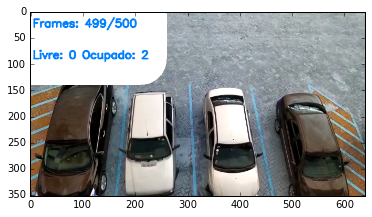

In [22]:
im = frame_out.copy()
cv2.drawContours(im,parking_contours[1],-1,(255,255,0),3)
plt.imshow(im)
plt.show()

 

In [20]:
 parking_contours[0]

array([[[445, 372]],

       [[445, 671]]], dtype=int32)

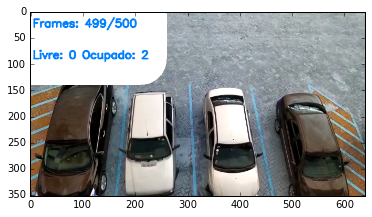

In [29]:
im = frame_out.copy()
x,y,w,h = cv2.boundingRect(parking_contours[0])
cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(im)
plt.show()